# IMPORT LIBRIARIES

## Load carbon emission data

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor


In [2]:
carb=pd.read_csv("/content/carbon.csv")
carbon_data=carb[["Year","total_population","Avg_Carbon_emmsion_per capita","avg_temp_change"]]
carbon_data["total_population"]=carbon_data["total_population"].apply(pd.np.log)
carbon_data.head()

,Year,total_population,Avg_Carbon_emmsion_per capita,avg_temp_change
0,1961,24.159987,3.326700,0.144488
1,1962,24.177561,3.498224,-0.028981
2,1963,24.199008,3.946614,-0.026252
3,1964,24.220168,4.046382,-0.122131
4,1965,24.241396,4.067733,-0.224178


## Load weather Data

In [4]:
weather_data=pd.read_csv("/content/rainfall in india 1901-2015.csv")

## filter Year greater than 1960
weather_data=weather_data[weather_data["YEAR"]>1960]

## filter data based on Subdivision
weather_data=weather_data[weather_data["SUBDIVISION"]=='COASTAL KARNATAKA']

weather_data=weather_data.fillna(value=0)
weather_data.index=weather_data["YEAR"]
weather_data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
YEAR,,,,,,,,,,,,,,,,,,,
1961,COASTAL KARNATAKA,1961,0.0,0.0,0.9,47.7,635.0,1013.0,1884.9,936.3,702.8,309.6,21.0,2.7,5553.9,0.0,683.6,4536.9,333.4
1962,COASTAL KARNATAKA,1962,0.2,3.4,0.1,31.6,359.4,405.4,1307.9,1080.9,413.5,313.4,18.5,83.3,4017.7,3.6,391.1,3207.7,415.3
1963,COASTAL KARNATAKA,1963,1.1,0.7,28.6,38.5,86.0,682.3,887.6,1013.8,181.0,233.7,8.2,10.0,3171.3,1.8,153.0,2764.7,251.8
1964,COASTAL KARNATAKA,1964,0.0,0.0,2.6,5.8,23.4,631.7,864.0,978.1,363.9,200.2,53.1,17.6,3140.5,0.0,31.8,2837.8,271.0
1965,COASTAL KARNATAKA,1965,2.5,0.0,0.0,9.7,39.7,797.8,1002.5,577.2,196.8,25.1,20.1,159.8,2831.1,2.5,49.4,2574.2,205.0


### unstack data columns "Months" into roles

In [5]:
_data=weather_data[
    ['JAN',
     'FEB',
     'MAR',
     'APR',
     'MAY',
     'JUN',
     'JUL',
     'AUG',
     'SEP',
     'OCT',
     'NOV',
     'DEC']]
_data.columns=['01-JAN',
 '02-FEB',
 '03-MAR',
 '04-APR',
 '05-MAY',
 '06-JUN',
 '07-JUL',
 '08-AUG',
 '09-SEP',
 '10-OCT',
 '11-NOV',
 "12-DEC"]
_data=_data.unstack().reset_index(name="value")

### Merge the carbon and weather dataset

In [6]:
data=pd.merge(_data.sort_values(by=['YEAR','level_0']),carbon_data,left_on="YEAR",right_on="Year")[['level_0',
 'Year',"value",
 'total_population',
 'Avg_Carbon_emmsion_per capita',
 'avg_temp_change']]

# Data exploration

In [7]:
data.describe()

,Year,value,total_population,Avg_Carbon_emmsion_per capita,avg_temp_change
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,1988.000000,292.753939,24.665035,4.807058,0.404550
std,15.886548,406.887090,0.272639,0.631570,0.416684
min,1961.000000,0.000000,24.159987,3.326700,-0.224178
25%,1974.000000,3.700000,24.432779,4.413151,0.073026
50%,1988.000000,69.800000,24.692304,4.738343,0.281509
75%,2002.000000,496.275000,24.910377,5.203349,0.817206
max,2015.000000,1884.900000,25.077436,6.330283,1.326988


## data split

In [8]:
test_data=data[501:]
train_data=data[:501]

In [9]:
header=list(train_data.columns)
target="value"
header.remove(target)

## Hot Encode data

In [18]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [19]:
import category_encoders as ce
encoder=ce.OneHotEncoder()
encoder.fit(train_data[header],train_data[target])
transformed_train=encoder.transform(train_data[header])

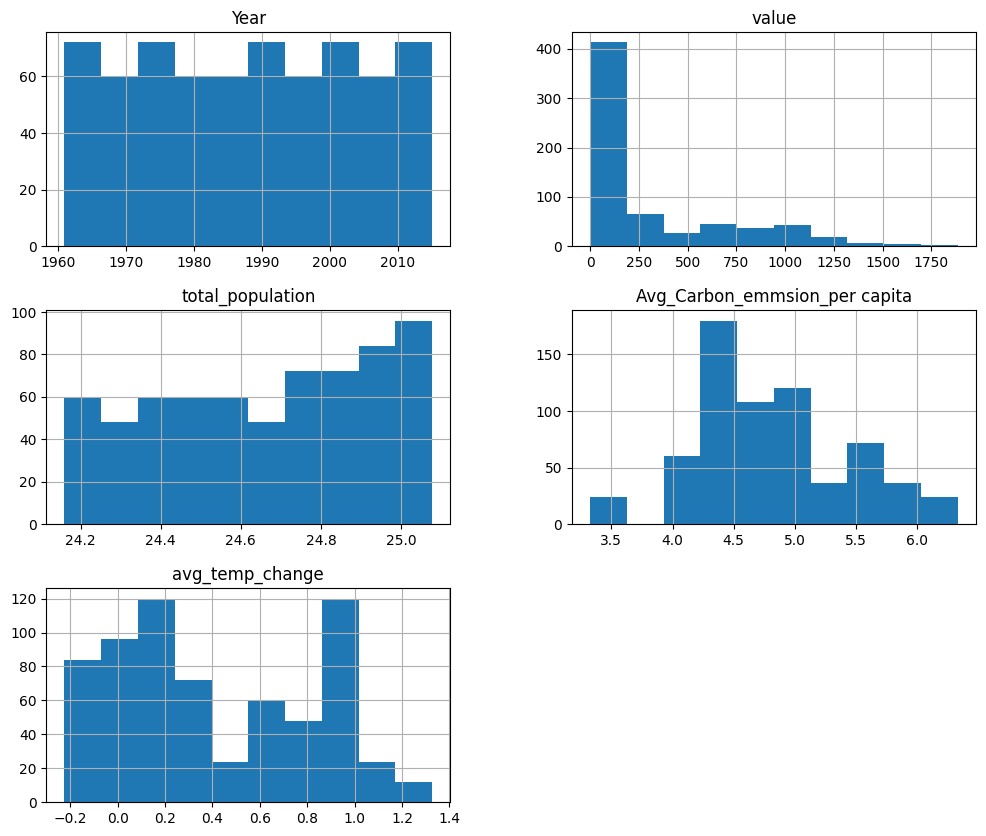

In [20]:
data.hist(figsize = (12,10))
plt.show()

# Neutral Network Model

In [21]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(32, kernel_initializer='normal',input_dim = transformed_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(16, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(4, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Save models

In [22]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Train Model

In [23]:
NN_model.fit(transformed_train, train_data[target], epochs=800, batch_size=12, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/800
22/34 [==================>...........] - ETA: 0s - loss: 277.9907 - mean_absolute_error: 277.9907 
Epoch 1: val_loss improved from inf to 311.00473, saving model to Weights-001--311.00473.hdf5
34/34 [==============================] - 1s 10ms/step - loss: 288.2567 - mean_absolute_error: 288.2567 - val_loss: 311.0047 - val_mean_absolute_error: 311.0047
Epoch 2/800
28/34 [=======================>......] - ETA: 0s - loss: 299.7333 - mean_absolute_error: 299.7333
Epoch 2: val_loss improved from 311.00473 to 309.83258, saving model to Weights-002--309.83258.hdf5
34/34 [==============================] - 0s 4ms/step - loss: 287.9404 - mean_absolute_error: 287.9405 - val_loss: 309.8326 - val_mean_absolute_error: 309.8326
Epoch 3/800
29/34 [========================>.....] - ETA: 0s - loss: 281.9633 - mean_absolute_error: 281.9633
Epoch 3: val_loss improved from 309.83258 to 301.33160, saving model to Weights-003--301.33160.hdf5
34/34 [==============================] - 0s 4ms/step - l

## Download weights

In [24]:
from IPython.display import FileLinks
FileLinks(".")

./
  Weights-180--294.58475.hdf5
  Weights-200--291.00107.hdf5
  Weights-552--84.77763.hdf5
  Weights-202--290.49716.hdf5
  Weights-267--99.15730.hdf5
  carbon.csv
  Weights-229--142.87506.hdf5
  Weights-249--115.55874.hdf5
  Weights-382--89.30989.hdf5
  Weights-213--267.69687.hdf5
  Weights-205--289.27173.hdf5
  Weights-214--256.88132.hdf5
  Weights-183--294.25638.hdf5
  Weights-244--119.43921.hdf5
  Weights-222--174.60799.hdf5
  Weights-152--295.33643.hdf5
  Weights-476--87.80801.hdf5
  Weights-235--130.45287.hdf5
  Weights-315--91.58018.hdf5
  Weights-286--94.68541.hdf5
  Weights-346--89.47212.hdf5
  Weights-209--283.11398.hdf5
  rainfall in india 1901-2015.csv
  Weights-212--273.21863.hdf5
  Weights-178--294.74295.hdf5
  Weights-206--287.17606.hdf5
  Weights-181--294.58109.hdf5
  Weights-117--295.86172.hdf5
  Weights-223--164.22314.hdf5
  Weights-219--184.52104.hdf5
  Weights-220--178.81392.hdf5
  Weights-247--116.40198.hdf5
  Weights-221--174.84880.hdf5
  Weights-471--88.52103.hdf5
  Weights-196--292.68600.hdf5
  Weights-633--82.95525.hdf5
  Weights-553--84.71387.hdf5
  Weights-599--83.61707.hdf5
  Weights-198--291.74765.hdf5
  Weights-271--96.01743.hdf5
  Weights-124--295.84711.hdf5
  Weights-268--97.02303.hdf5
  Weights-430--89.25896.hdf5
  Weights-058--295.88062.hdf5
  Weights-227--148.77081.hdf5
  Weights-225--158.40407.hdf5
  Weights-593--83.93576.hdf5
  Weights-327--90.03574.hdf5
  Weights-506--85.02807.hdf5
  Weights-203--289.40750.hdf5
  Weights-258--100.25188.hdf5
  Weights-185--293.82654.hdf5
  Weights-477--86.10834.hdf5
  Weights-151--295.56998.hdf5
  Weights-194--292.73715.hdf5
  Weights-003--301.33160.hdf5
  Weights-191--293.16592.hdf5
  Weights-250--111.13242.hdf5
  Weights-004--296.07050.hdf5
  Weights-144--295.58835.hdf5
  Weights-216--216.42584.hdf5
  Weights-210--281.24860.hdf5
  Weights-458--88.89967.hdf5
  Weights-193--292.90463.hdf5
  Weights-513--84.92876.hdf5
  Weights-208--284.96103.hdf5
  Weights-318--90.53912.hdf5
  Weights-517--84.79759.hdf5
  Weights-207--286.27066.hdf5
  Weights-130--295.64667.hdf5
  Weights-189--293.77029.hdf5
  Weights-234--131.03850.hdf5
  Weights-739--82.66892.hdf5
  Weights-240--122.34835.hdf5
  Weights-252--107.75970.hdf5
  Weights-201--290.49924.hdf5
  Weights-184--294.19699.hdf5
  Weights-197--292.10092.hdf5
  Weights-158--295.09833.hdf5
  Weights-002--309.83258.hdf5
  Weights-280--95.89721.hdf5
  Weights-215--233.72586.hdf5
  Weights-001--311.00473.hdf5
  Weights-170--294.77328.hdf5
  Weights-285--94.97563.hdf5
  Weights-455--89.07556.hdf5
  Weights-199--291.12234.hdf5
  Weights-237--126.16482.hdf5
  Weights-211--278.34723.hdf5
  Weights-126--295.77954.hdf5
  Weights-190--293.72400.hdf5
  Weights-293--93.60370.hdf5
./.config/
  .last_survey_prompt.yaml
  active_config
  default_configs.db
  gce
  .last_opt_in_prompt.yaml
  .last_update_check.json
  config_sentinel
./.config/configurations/
  config_default
./.config/logs/2023.11.03/
  18.00.39.484927.log
  18.00.06.856125.log
  18.00.18.330056.log
  18.00.27.780630.log
  17.59.39.197392.log
  18.00.40.388891.log
./sample_data/
  anscombe.json
  README.md
  mnist_test.csv
  california_housing_train.csv
  california_housing_test.csv
  mnist_train_small.csv

# Predict  this month's  rainfall

In [25]:
NN_model.predict(np.array([[0,0	,0,	0,	0,	0,	1,	0,	0,	0,	0,	0,	2021,	24.910377,	4.621587,	0.926928]]))[0][0]

1/1 [==============================] - 0s 66ms/step


1128.2424

# Predict  Next month's  rainfall

In [26]:
NN_model.predict(np.array([[0,0 ,0, 0,  0,  0,  0,  1,  0,  0,  0,  0,  2021,   24.910377,  4.621587,   0.926928]]))[0][0]

1/1 [==============================] - 0s 19ms/step


805.1434